# Observed Iceberg Input

In [60]:
import urllib
import pandas as pd
import numpy as np
from sklearn import datasets

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
import xarray as xr
import scipy.interpolate as interp

import scipy.io as sio
import numpy.matlib
import cmath

In [100]:
# Choose iceberg year (2002 - 2015 available)
# Note: Iceberg Season starts in November so many datasets include dates from year-1
season_year = 2015
iip_url_base = 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G00807/' 
iip_filename = f'IIP_{season_year}IcebergSeason.csv'
iip_url = iip_url_base + iip_filename
r = urllib.request.urlretrieve(iip_url)
df = pd.read_csv(r[0], converters={'TIME':str})
df['DATETIME'] = pd.to_datetime(df['DATE'] + 'T' + df['TIME'])

In [62]:
# Choose the min number of observations for an eligible iceberg
min_num_obs = 10
eligible_bergs = np.asarray(
    df['BERG_NUMBER'].value_counts()\
    .loc[df['BERG_NUMBER'].value_counts() > min_num_obs].index)

In [63]:
chosen_inds_arr = []

for i in range(eligible_bergs.size):

    berg_id = eligible_bergs[i]
    berg_df = df.loc[df['BERG_NUMBER'] == berg_id]
    
    ind0 = berg_df.index.tolist()[0]
    indf = berg_df.index.tolist()[-1]
    
    max_time_dif = np.timedelta64(24*60*3, 'm')
    
    chosen_inds = []

    for j in range(len(berg_df)-1):

        time_dif = (berg_df.DATETIME.values[j+1] - \
                    berg_df.DATETIME.values[j]).astype('timedelta64[m]')
        
        if time_dif < max_time_dif:
            chosen_inds.append(j+ind0)

        elif len(chosen_inds) > 5:
            chosen_inds_arr.append(chosen_inds)
            chosen_inds = []
        else:
            chosen_inds = []

    if len(chosen_inds) > 5:
        chosen_inds_arr.append(chosen_inds)

In [102]:
# Choose which iceberg track to look at (index)
chosen_track_ind = 2

berg_df = df.loc[chosen_inds_arr[chosen_track_ind]]
berg_date_i = berg_df['DATETIME'].dt.values[0]
berg_date_f = berg_df['DATETIME'].dt.values[-1]
date2000 = np.datetime64('2000-01-01')
hour_since_i = (berg_date_i - date2000).days*24
hour_since_f = (berg_date_f - date2000).days*24 + 24  # add an extra day
hour_dif = hour_since_f - hour_since_i
berg_df['hrs_since'] =  (berg_df['DATETIME'].dt.values - berg_df['DATETIME'].dt.values[0]).days*24 + \
(berg_df['DATETIME'].dt.values - berg_df['DATETIME'].dt.values[0]).seconds/3600
berg_min_lat = min(berg_df['LATITUDE'].tolist())
berg_max_lat = max(berg_df['LATITUDE'].tolist())
berg_min_lon = min(berg_df['LONGITUDE'].tolist())
berg_max_lon = max(berg_df['LONGITUDE'].tolist())

# Ocean Input

In [103]:
glb_url = 'http://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_56.3'
glb_ds = xr.open_dataset(glb_url, decode_times=False)
# June 1, 00:00 = 135120., July 1, 00:00 = 135840.
glb_ds = glb_ds.sel(depth=0.0, 
                    lat = slice(berg_min_lat-1, berg_max_lat+1), 
                    lon = slice(berg_min_lon-1, berg_min_lon+1), 
                    time=slice(hour_since_i, hour_since_f))
water_u_data = glb_ds.water_u
water_v_data = glb_ds.water_v
water_temp_data = glb_ds.water_temp
glb_times = np.asarray(water_u_data.time)
glb_lats = np.asarray(water_u_data.lat)
glb_lons = np.asarray(water_u_data.lon)
glb_times = glb_times - hour_since_i

#### Warning -- the box below takes a few minutes to run

In [104]:
water_u = np.asarray(water_u_data)
water_v = np.asarray(water_v_data)
water_temp = np.asarray(water_temp_data)

In [105]:
water_u_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_u)
water_v_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_v)
water_temp_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_temp)

# Atmosphere Inputs

In [126]:
atm_time_res = 6

In [127]:
navgem_url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D10mWind_LonPM180'
navgem_ds = xr.open_dataset(navgem_url)
berg_date2_i = '{}-{}-{}' .format(berg_df['DATETIME'].dt.values.year[0],
                                 berg_df['DATETIME'].dt.values.month[0],
                                 berg_df['DATETIME'].dt.values.day[0])
berg_date2_f = '{}-{}-{}' .format((berg_df['DATETIME'].dt.values[-1] + pd.Timedelta('1 days')).year,
                                 (berg_df['DATETIME'].dt.values[-1] + pd.Timedelta('1 days')).month,
                                 (berg_df['DATETIME'].dt.values[-1] + pd.Timedelta('1 days')).day)
navgem_ds = navgem_ds.sel(time=slice(berg_date2_i, berg_date2_f), 
                          latitude=slice(berg_min_lat-1, berg_max_lat+1), 
                          longitude=slice(berg_min_lon-1, berg_max_lon+1))

In [128]:
wind_u = navgem_ds.wnd_ucmp_height_above_ground
wind_v = navgem_ds.wnd_vcmp_height_above_ground
navgem_times = np.arange(0, navgem_ds.time.size*atm_time_res, atm_time_res)
navgem_lats = np.asarray(wind_u.latitude)
navgem_lons = np.asarray(wind_u.longitude)

In [129]:
wind_u = np.asarray(wind_u[:,0,:,:])
wind_v = np.asarray(wind_v[:,0,:,:])

In [130]:
wind_u_interp = interp.RegularGridInterpolator((navgem_times, navgem_lats, navgem_lons), wind_u)
wind_v_interp = interp.RegularGridInterpolator((navgem_times, navgem_lats, navgem_lons), wind_v)

# Model

In [131]:
# Constants
R = 6378*1e3
om = 7.2921e-5
rhow = 1027
rhoa = 1.2
rhoi = 850
drho = rhow - rhoi
Cw = 0.9
Ca = 1.3
gam = np.sqrt(rhoa*drho/rhow/rhoi*(Ca/Cw))
sst0 = -4
Cs1 = 1.5; Cs2 = 0.5; Cs3 = 0.1
CMv1 = 7.62e-3; CMv2 = 1.29e-3; CMe1 = 0.5
CMb1 = 0.58; CMb2 = 0.8; CMb3 = 0.2

In [132]:
def iceDEF(t,x,y,l,w,h):

    # Extract values from input fields
    
    vau = wind_u_interp([t, y, x])[0]
    vav = wind_v_interp([t, y, x])[0]  
    vwu = water_u_interp([t, y, x])[0] 
    vwv = water_v_interp([t, y, x])[0]
    sst = water_temp_interp([t, y, x])[0]
    
    
    # Drifting

    S = np.pi*((l*w)/(l+w))
    ff = 2*om*np.sin((np.abs(y)*np.pi)/180)
    lam = np.sqrt(2)*Cw*(gam*np.sqrt(vau**2 + vav**2))/(ff*S)

    
    if lam < 0.1:
        alpha = lam*(lam**4*(lam**4*(lam**4*(-0.0386699020961393*lam**4 + \
            0.055242717280199) - 0.0883883476483184) + \
            0.176776695296637) - 0.707106781186548)
    else:
        alpha = np.multiply(np.divide(np.sqrt(2),np.power(lam, 3)),(1-np.sqrt(1+np.power(lam,4))))
        
    if lam < 0.6:
        beta = lam**3*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*\
            (0.0153268598203613*lam**4 - 0.0151656272365985) + \
            0.0180267866272764) + 0.0219176256311202) - \
            0.0274446790511418) + 0.0357675015202851) - \
            0.0493731785691779) + 0.0745776683282687) - \
            0.132582521472478) + 0.353553390593274)
    else:
        beta = np.real(np.multiply(np.divide(1.,np.power(lam,3.)),cmath.sqrt(np.multiply((4.+np.power(lam,4.)), \
            cmath.sqrt(1.+np.power(lam,4.)))-3.*np.power(lam,4.)-4.)))

        
    viu = vwu + gam*(-alpha*vav + beta*vau)
    viv = vwv + gam*(alpha*vau + beta*vav)

    y_new = y + (viv*dt)*(180/(np.pi*R))
    x_new = x + (viu*dt)/(np.cos((((y + y_new)/2)*np.pi)/180))*(180/(np.pi*R))
    
    
    # Melting

    Me = CMe1*(Cs1*np.sqrt(vau**2 + vav**2)**Cs2 + Cs3*np.sqrt(vau**2 + vav**2))
    Mv = CMv1*sst + CMv2*sst**2
    Mb = CMb1*np.power(np.sqrt(np.square(viu-vwu)+np.square(viv-vwv)),CMb2)*(sst - sst0)/l**CMb3

    l_new = l - (Mv + Me)*(dt/(24*3600))  # convert dt from secs to days
    w_new = w - (Mv + Me)*(dt/(24*3600))
    h_new = h - Mb*(dt/(24*3600))

    if w_new < 0.85*h_new:
        # Rollover
        print('rollover')
        w_new, h_new = h_new, w_new

    if w_new > l_new:
        # Ensure l is greater than w
        print('swap l and w')
        w_new, l_new = l_new, w_new

    return x_new, y_new, l_new, w_new, h_new   

In [587]:
def get_berg_dims(size):
    # Size must be GR, BB, SM, MED, LG, VLG
    # See https://nsidc.org/data/g00807 for more info
    if size == 'GR':
        l = (0+5)/2; w = (0+5)/2; h = (0+1)/2*10
    elif size == 'BB':
        l = (5+15)/2; w = (5+15)/2; h = (1+5)/2*10        
    elif size == 'SM':
        l = (15+60)/2; w = (15+60)/2; h = (5+15)/2*10        
    elif size == 'MED':
        l = (60+120)/2; w = (60+120)/2; h = (15+45)/2*10               
    elif size == 'LG':
        l = (120)/2; w = (120)/2; h = (45+75)/2*10                
    elif size == 'VLG':
        # Sizes have no listed upper bound
        l = (200+200/2)/2; w = (200+200/2)/2; h = (75+75/2)/2*10     
    # This info for GEN is wrong!
    elif size == 'GEN':
        l = (120)/2; w = (120)/2; h = (45+75)/2*10            
    else:
        print('unknown size class')
        l = None; w = None; h = None
    return l, w, h

In [160]:
# Timesteps
t0 = 0  # initial hour
t_inc = 0.1  # hours
num_hrs = np.ceil(berg_df['hrs_since'].values[-1])
tn = t_inc*num_hrs  # total number of timesteps
dt = t_inc*3600  # model timestep in seconds
tf = t0 + tn*dt  # final timestep in seconds  
t_all = np.arange(t0, num_hrs, t_inc)

In [588]:
# Iceberg Initial Location
x0, y0 = berg_df.LONGITUDE.values[0], berg_df.LATITUDE.values[0]

# Run number
run_num = 0
num_runs = 1

# Buffer number for bounding spatial box
buf = 0.5

# Manual stop time
stop_time = 36
#stop_time = t_all[-1]

# Initialize output dict
output_dict = {}

for run_num in range(num_runs):
    
    # Iceberg Initials
    l0, w0, h0 = get_berg_dims(berg_df['SIZE'].values[0])
    l0 = l0 + l0*0.1*run_num
    w0 = w0 + w0*0.1*run_num
    h0 = h0 + h0*0.1*run_num
    l, w, h = l0, w0, h0
    x, y = x0, y0
    t = t_all[0]
    iceberg = np.array([[t0],[x0],[y0],[l0],[w0],[h0]])

    print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))
    
    while t < stop_time:
        
        #print('Timestep: {}'.format(t))

        x_new, y_new, l_new, w_new, h_new = iceDEF(t, x, y, l, w, h)

        if x_new > berg_max_lon+buf or x_new < berg_min_lon-buf or y_new > berg_max_lat+buf or y_new <= berg_min_lat-buf:
            # Iceberg out-of-bounds
            print('out-of-bounds')
            break


        if l_new <= 0 or w_new <= 0 or h_new <= 0:
            # Iceberg melted
            print('melted')
            break

        else:
            x, y, l, w, h = x_new, y_new, l_new, w_new, h_new
            t += t_inc
            iceberg_new = np.array([[t],[x],[y],[l],[w],[h]])
            iceberg = np.column_stack((iceberg, iceberg_new))

    print("Final time: {}".format(t))

Run number: 0, h = 600.0, l = 60.0, w = 60.0
rollover
swap l and w
Final time: 36.00000000000024


# Plotting

In [549]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.basemap import Basemap
import bisect
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

In [550]:
def plot1(berg_df, iceberg):
    # t is the last timestep the model used
    t = iceberg[0,-1]
    t_all = iceberg[0,:]
    nbt = berg_df.loc[abs(berg_df['hrs_since'] - t) == min(abs(berg_df['hrs_since'] -t))].index.values[0] - berg_df.index[0] # nearest berg time index from 0
    plt.plot(berg_df['LONGITUDE'].values[:nbt+1], berg_df['LATITUDE'].values[:nbt+1], 
             label='observed', marker='o') 
    plt.plot(iceberg[1,:],iceberg[2,:], label='computed')
    for k in range(nbt+1):
        plt.annotate('{0:.1f}'.format(berg_df['hrs_since'].values[k]), 
                     xy=(berg_df['LONGITUDE'].values[k],
                         berg_df['LATITUDE'].values[k]))
        tmp_diff = abs(t_all - berg_df['hrs_since'].values[k])
        tmp_i = np.where(tmp_diff == tmp_diff.min())[0][0]
        if tmp_i >= iceberg[0,:].size:
            plt.annotate('{0:.1f}'.format(iceberg[0,-1]), 
                     xy=(iceberg[1,-1],iceberg[2,-1]))
            plt.plot(iceberg[1,-1],iceberg[2,-1], marker='o', color='black')
        else:
            plt.annotate('{0:.1f}'.format(t_all[tmp_i]), 
                     xy=(iceberg[1,tmp_i],iceberg[2,tmp_i]))
            plt.plot(iceberg[1,tmp_i],iceberg[2,tmp_i], marker='o', color='black')

        
    plt.plot(iceberg[1,:],iceberg[2,:], label='computed')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.title('Iceberg Drift\nSeason year: {}\nIIP indices: {}'.format(season_year, chosen_inds_arr[chosen_track_ind][:nbt+1]))
    plt.savefig('./drift_track1.png')
    plt.show()

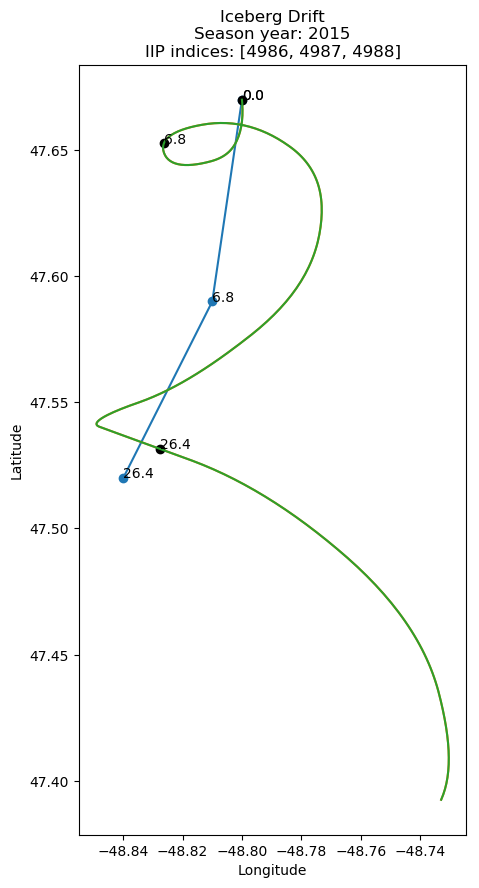

In [589]:
plot1(berg_df, iceberg)

In [551]:
def plot2(berg_df, iceberg):
    
    obs_lats = berg_df['LATITUDE'].tolist()
    obs_lons = berg_df['LONGITUDE'].tolist()
    obs_times = berg_df['hrs_since'].tolist()
    com_lats = iceberg[2,:]
    com_lons = iceberg[1,:]
    com_times = iceberg[0,:]
    
    # find the max time (in hours)
    max_t = min(max(obs_times), max(com_times))
    
    # trim data to max time
    obs_ind = bisect.bisect_right(obs_times, max_t)
    obs_times = obs_times[:obs_ind+1]
    obs_lats = obs_lats[:obs_ind+1]
    obs_lons = obs_lons[:obs_ind+1]
    
    # find a bounding box in space
    min_lat = min(min(obs_lats), min(com_lats))
    max_lat = max(max(obs_lats), max(com_lats))
    min_lon = min(min(obs_lons), min(com_lons))
    max_lon = max(max(obs_lons), max(com_lons))
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    buf = 0.1
    ax.set_extent([min_lon-buf, max_lon+buf, min_lat-buf, max_lat+buf], ccrs.PlateCarree())
    #ax.stock_img()
    ax.coastlines('50m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
    
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
        
    labels = [round(elem, 1) for elem in obs_times] 
    for label, x, y in zip(labels, obs_lons, obs_lats):
        ax.plot(x, y, marker='o', color='red')
        ax.text(x, y, label)
    
    for i, i2 in enumerate(com_times):
        for j in labels:
            if abs(com_times[i] - j) < 0.001:
                ax.plot(com_lons[i], com_lats[i], marker='X', color='green')
                ax.text(com_lons[i], com_lats[i], j)
    
    ax.plot(obs_lons, obs_lats, color='red')
    ax.plot(com_lons, com_lats, color='green')
    
    plt.savefig('./drift_track2.png')
    plt.show()

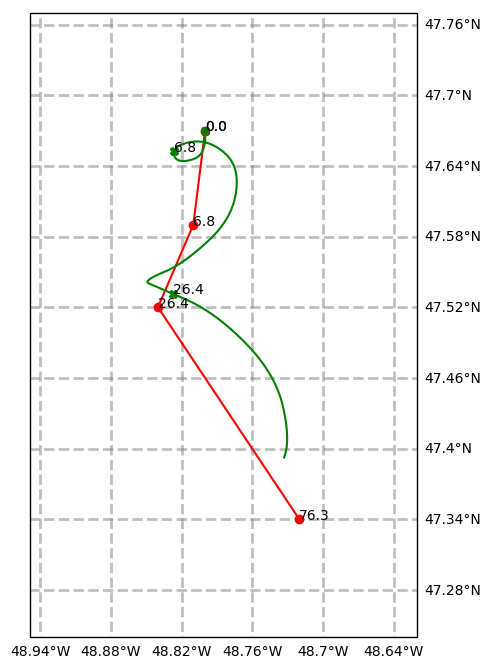

In [590]:
plot2(berg_df, iceberg)

In [584]:
def plot3(berg_df, iceberg):

    obs_lats = berg_df['LATITUDE'].tolist()
    obs_lons = berg_df['LONGITUDE'].tolist()
    obs_times = berg_df['hrs_since'].tolist()
    com_lats = iceberg[2,:]
    com_lons = iceberg[1,:]
    com_times = iceberg[0,:]
    
    # find the max time (in hours)
    max_t = min(max(obs_times), max(com_times))
    
    # trim data to max time
    obs_ind = bisect.bisect_right(obs_times, max_t)
    obs_times = obs_times[:obs_ind+1]
    obs_lats = obs_lats[:obs_ind+1]
    obs_lons = obs_lons[:obs_ind+1]
    
    # find a bounding box in space
    min_lat = min(min(obs_lats), min(com_lats))
    max_lat = max(max(obs_lats), max(com_lats))
    min_lon = min(min(obs_lons), min(com_lons))
    max_lon = max(max(obs_lons), max(com_lons))
    
    m = Basemap(llcrnrlon=min_lon-0.1, llcrnrlat=min_lat-0.1, urcrnrlon=max_lon+0.1, urcrnrlat=max_lat+0.1)
    
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='coral',lake_color='aqua')

    # labels = [left,right,top,bottom]
    parallels = np.arange(min_lat, max_lat, 0.1)
    m.drawparallels(parallels,labels=[False,True,False,False])
    meridians = np.arange(min_lon, max_lon, 0.1)
    meridians = m.drawmeridians(meridians,labels=[False,False,True,False])
    for mer in meridians:
        try:
            meridians[mer][1][0].set_rotation(45)
        except:
            pass
    
    obs_xpt, obs_ypt = m(obs_lons, obs_lats)
    com_xpt, com_ypt = m(com_lons, com_lats)
    m.plot(obs_xpt, obs_ypt, 'o')
    m.plot(com_xpt, com_ypt, '.') 
    
    labels = [round(elem, 1) for elem in obs_times] 
    for label, x, y in zip(labels, obs_xpt, obs_ypt):
        plt.text(x, y, label)
    
    for i, i2 in enumerate(com_times):
        for j in labels:
            if abs(com_times[i] - j) < 0.001:
                plt.plot(com_lons[i], com_lats[i], marker='X', color='black')
                plt.text(com_lons[i], com_lats[i], j)
    
    #m.drawmapscale(lonn-buf/1.5, lat0+buf/5, lon0, lat0, length=100, barstyle='fancy')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.savefig('./drift_track3.png')
    plt.show()

/home/evankielley/.conda/envs/my_root/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/my_root/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


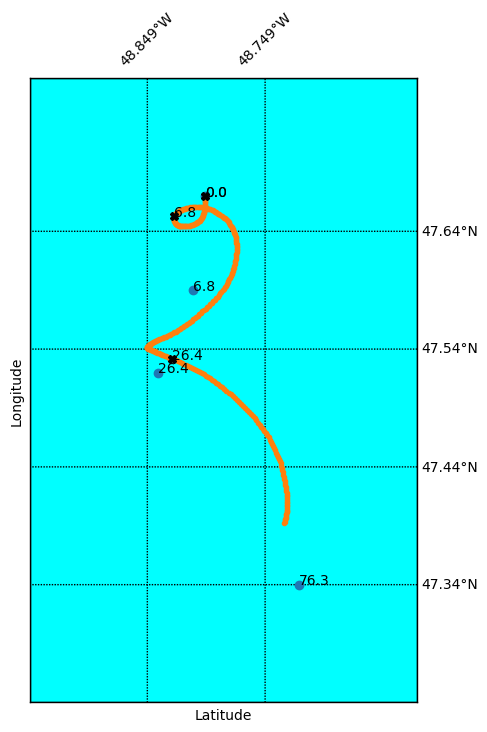

In [591]:
plot3(berg_df, iceberg)

# Save output dict

In [585]:
def make_output_dict(run_num, output_dict):
    if run_num == 0:
        output_dict = {
                        't_arr{}'.format(run_num): iceberg[0,:],
                        'x_arr{}'.format(run_num): iceberg[1,:],
                        'y_arr{}'.format(run_num): iceberg[2,:],
                        'l_arr{}'.format(run_num): iceberg[3,:],
                        'w_arr{}'.format(run_num): iceberg[4,:],
                        'h_arr{}'.format(run_num): iceberg[5,:]
                    }
    else:
        output_dict['t_arr{}'.format(run_num)] = iceberg[0,:]
        output_dict['x_arr{}'.format(run_num)] = iceberg[1,:]
        output_dict['y_arr{}'.format(run_num)] = iceberg[2,:]
        output_dict['l_arr{}'.format(run_num)] = iceberg[3,:]
        output_dict['w_arr{}'.format(run_num)] = iceberg[4,:]
        output_dict['h_arr{}'.format(run_num)] = iceberg[5,:]
        
    return output_dict